In [2]:
# coding=utf-8

In [ ]:
!pip install -U pip transformers

### 간단 정리

1. transformer의 변형(attention이 활용되기 시작)
2. Pretraining 모델
3. 단방향만 보는 LM(나중에 나온 BERT는 양방향)
4. 디코더형태의 단방향만 보는 모델
  강점: 생성모델에 활용가능
  단점: 양방향의 문맥을 고려하는 bert에 비해 문맥이해가 어렵다

기본 공개모델은 다음과 같은 transfomer 디코더의 변형을 12번 쌓은 모습
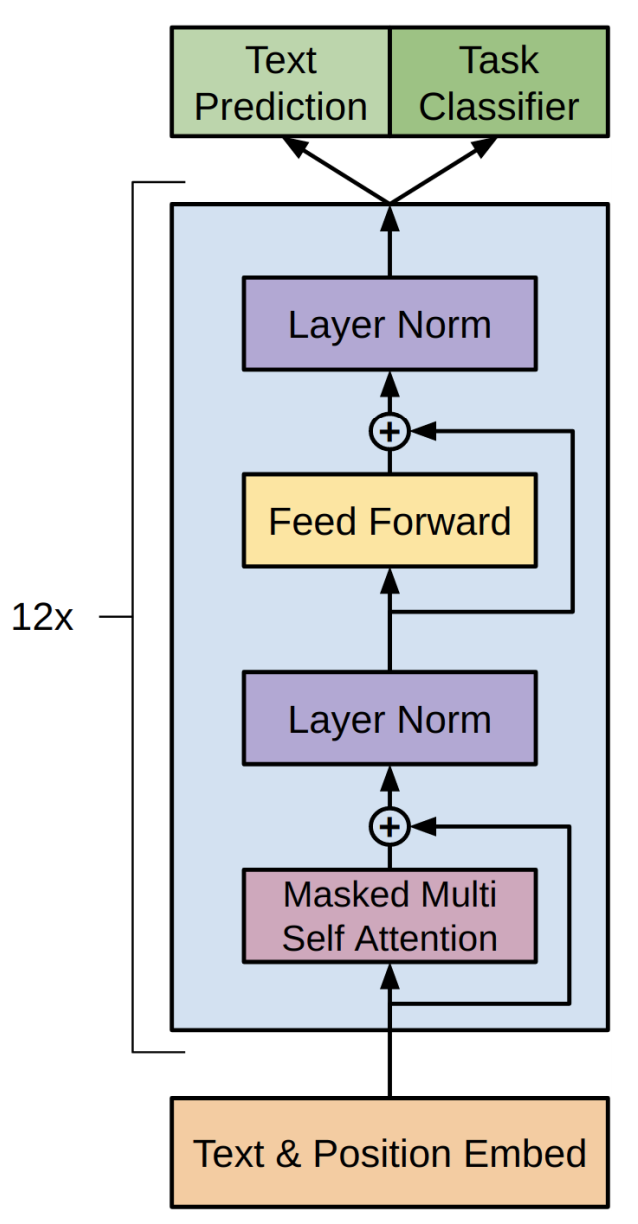



### 관련 코드파일들(코드명에 gpt라는 명칭은 없음, src/transformers/ 아래의 경로에 있음)
* configuration_openai
* tokenization_openai
* tokenization_openai

1. attention(modeling_openai.py - Attention 클래스)
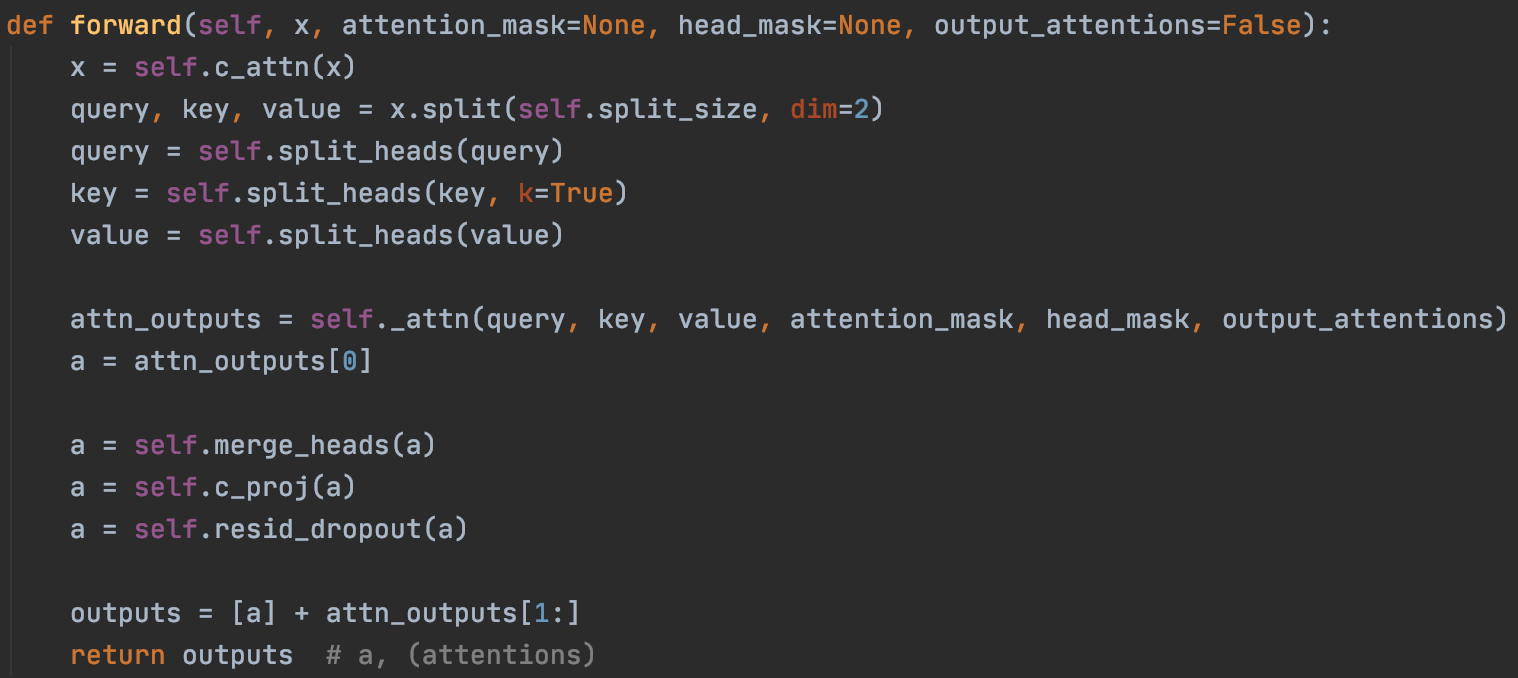
* 입력: X
* c_attn(x)을 통해 q,k,v의 형태로 만듬
* _attn(q,k,v,...)를 통해 어텐션 연산


공식문서에 설명이 잘 되어있습니다.
https://huggingface.co/transformers/model_doc/gpt.html

openai에서 작성한 원본 코드: https://github.com/openai/finetune-transformer-lm

[참고] 참고할만한 gpt 활용 예시
https://github.com/prrao87/tweet-stance-prediction/blob/master/transformer.ipynb

2. MLP(modeling_openai.py - MLP 클래스)
- Feed-forward network
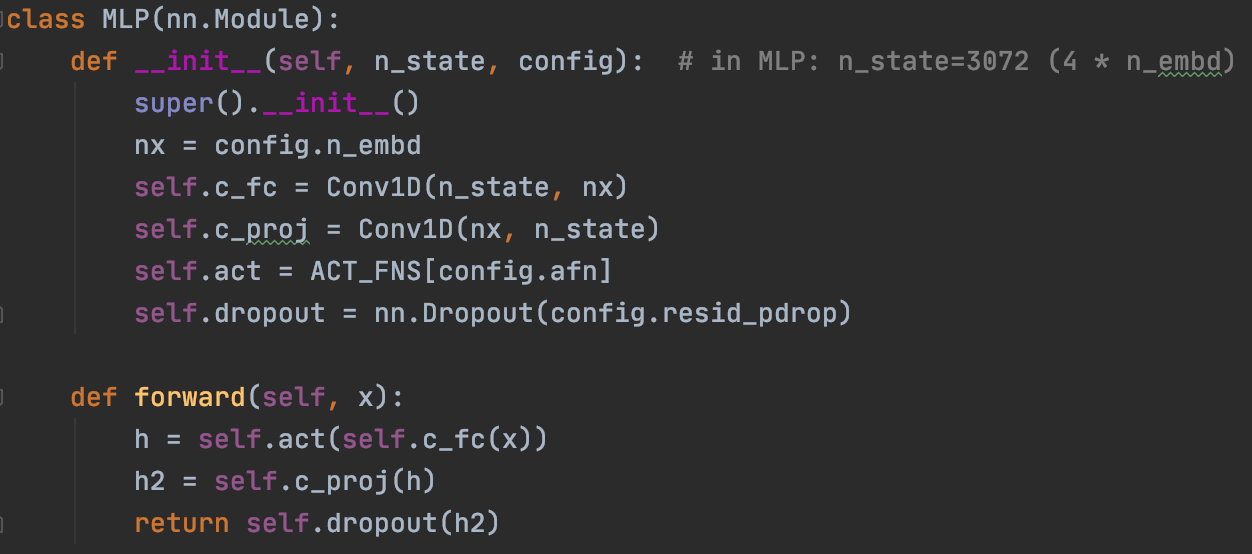

3. transformer block(modeling_openai.py Block 클래스), 전체 모델은 12개로 구성)
- (attn -> Lanyernorm -> MLP -> Layernorm)의 형태
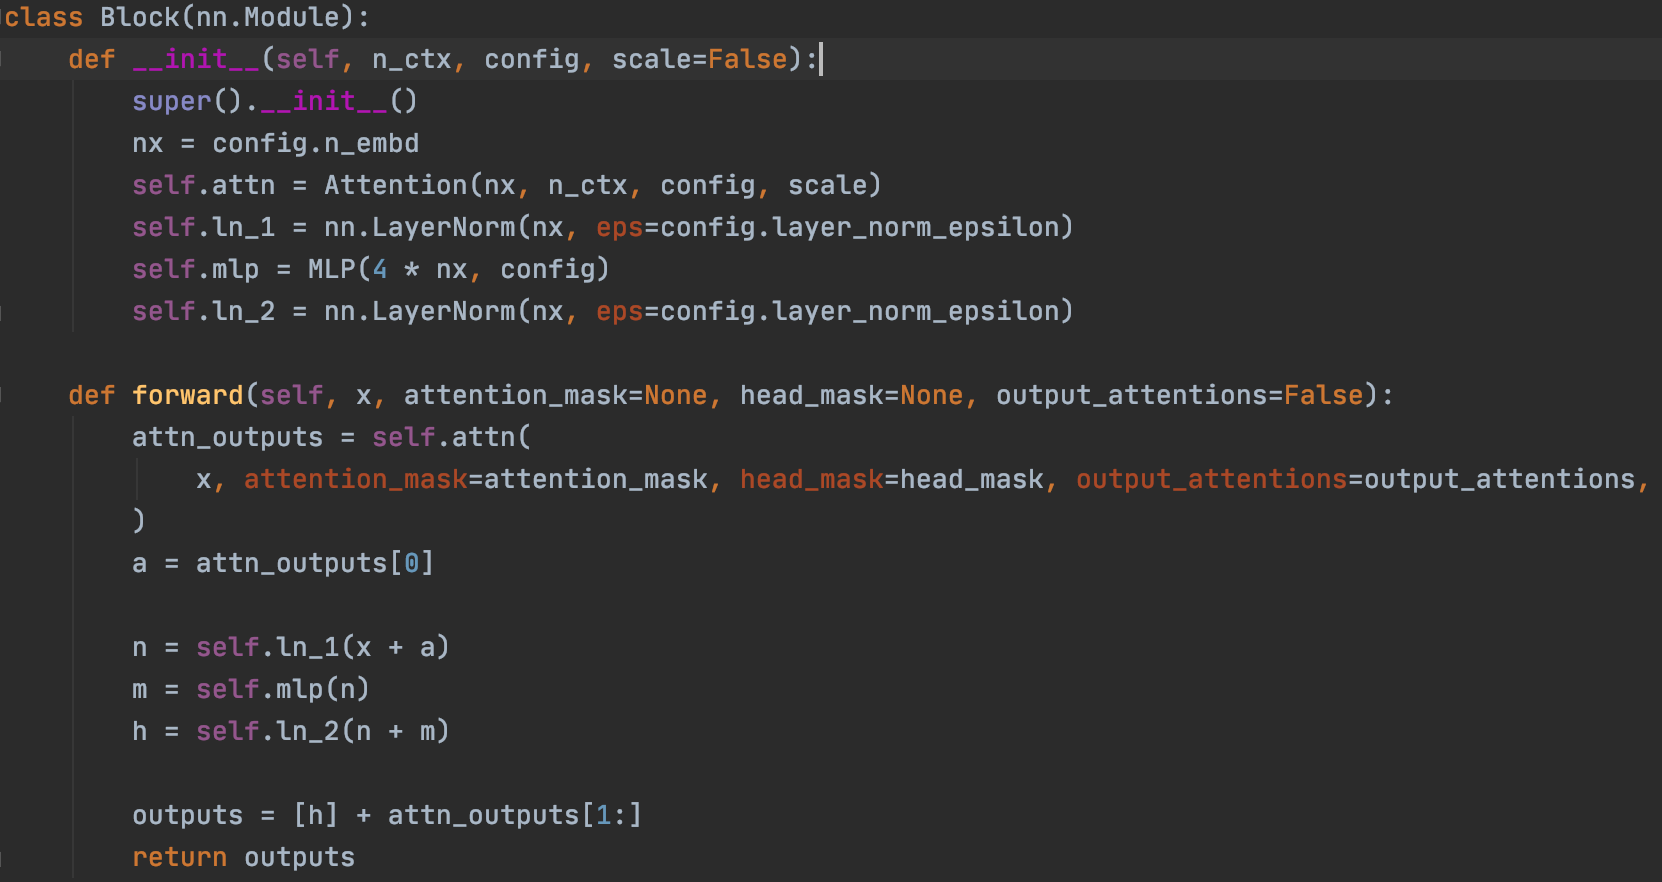

# 아래부터는 간단 코드 예시입니다.

## 미리 설치하라고 합니다.
* 미리 설치 & 데이터 파일들


In [ ]:
!pip install spacy ftfy==4.4.3
!python -m spacy download en

### OpenAIGPTConfig 모델 기본설정값 확인

In [5]:
from transformers import OpenAIGPTConfig, OpenAIGPTModel

# Initializing a GPT configuration
configuration = OpenAIGPTConfig()

# Initializing a model from the configuration
model = OpenAIGPTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [6]:
configuration

OpenAIGPTConfig {
  "afn": "gelu",
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "openai-gpt",
  "n_ctx": 512,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 512,
  "predict_special_tokens": true,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "vocab_size": 40478
}

### OpenAIGPTTokenizer 토크나이저 예시

In [31]:
from transformers import OpenAIGPTTokenizer, OpenAIGPTModel
import torch

tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

inputs = tokenizer("Hello, my dog is cute", return_tensors="np")

print(inputs)

{'input_ids': array([[3570,  240,  547, 2585,  544, 4957]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1]])}


### OpenAIGPTTokenizer 예시

In [23]:
from transformers import OpenAIGPTTokenizer, OpenAIGPTModel
import torch

tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
model = OpenAIGPTModel.from_pretrained('openai-gpt')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

# The last hidden-state is the first element of the output tuple
last_hidden_states = outputs[0]

In [24]:
last_hidden_states

tensor([[[ 0.4653,  0.0642,  0.5910,  ...,  0.1177, -0.0021, -1.2262],
         [-0.3697, -0.0957,  0.6613,  ..., -0.0344, -0.2164,  0.1205],
         [ 0.1700, -0.3252,  0.0407,  ...,  0.1589, -0.8057, -0.2830],
         [-0.3669, -0.0448,  0.8061,  ..., -0.0090, -0.0872, -0.5224],
         [-0.5047,  0.6522,  0.6932,  ...,  0.0811,  0.6475,  0.3190],
         [-0.2972,  0.0591,  1.2333,  ..., -0.7394, -0.2600,  0.0863]]],
       grad_fn=<ViewBackward>)

### OpenAIGPTLMHeadModel 쓰기 예시

In [35]:
import torch
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel

tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])

loss, logits = outputs[:2]

Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
logits

tensor([[[ -5.9486,  -5.8697, -18.4258,  ...,  -9.7371, -10.4495,   0.8814],
         [ -6.1212,  -4.8031, -14.3970,  ...,  -6.5411,  -9.5051,  -1.2015],
         [ -7.4231,  -6.3615, -14.7297,  ..., -10.4575,  -8.4600,  -1.5183],
         [ -5.6463,  -5.9526, -17.5195,  ...,  -9.4144, -15.7120,  -1.5394],
         [ -5.4751,  -5.8803, -13.7767,  ..., -10.5048, -12.4167,  -6.1584],
         [ -7.2052,  -6.0198, -21.5040,  ..., -16.2941, -14.0494,  -1.2416]]],
       grad_fn=<UnsafeViewBackward>)

### OpenAIGPTDoubleHeadsModel 예시
Double head?
* Language model: LM
* Multi classification: MC
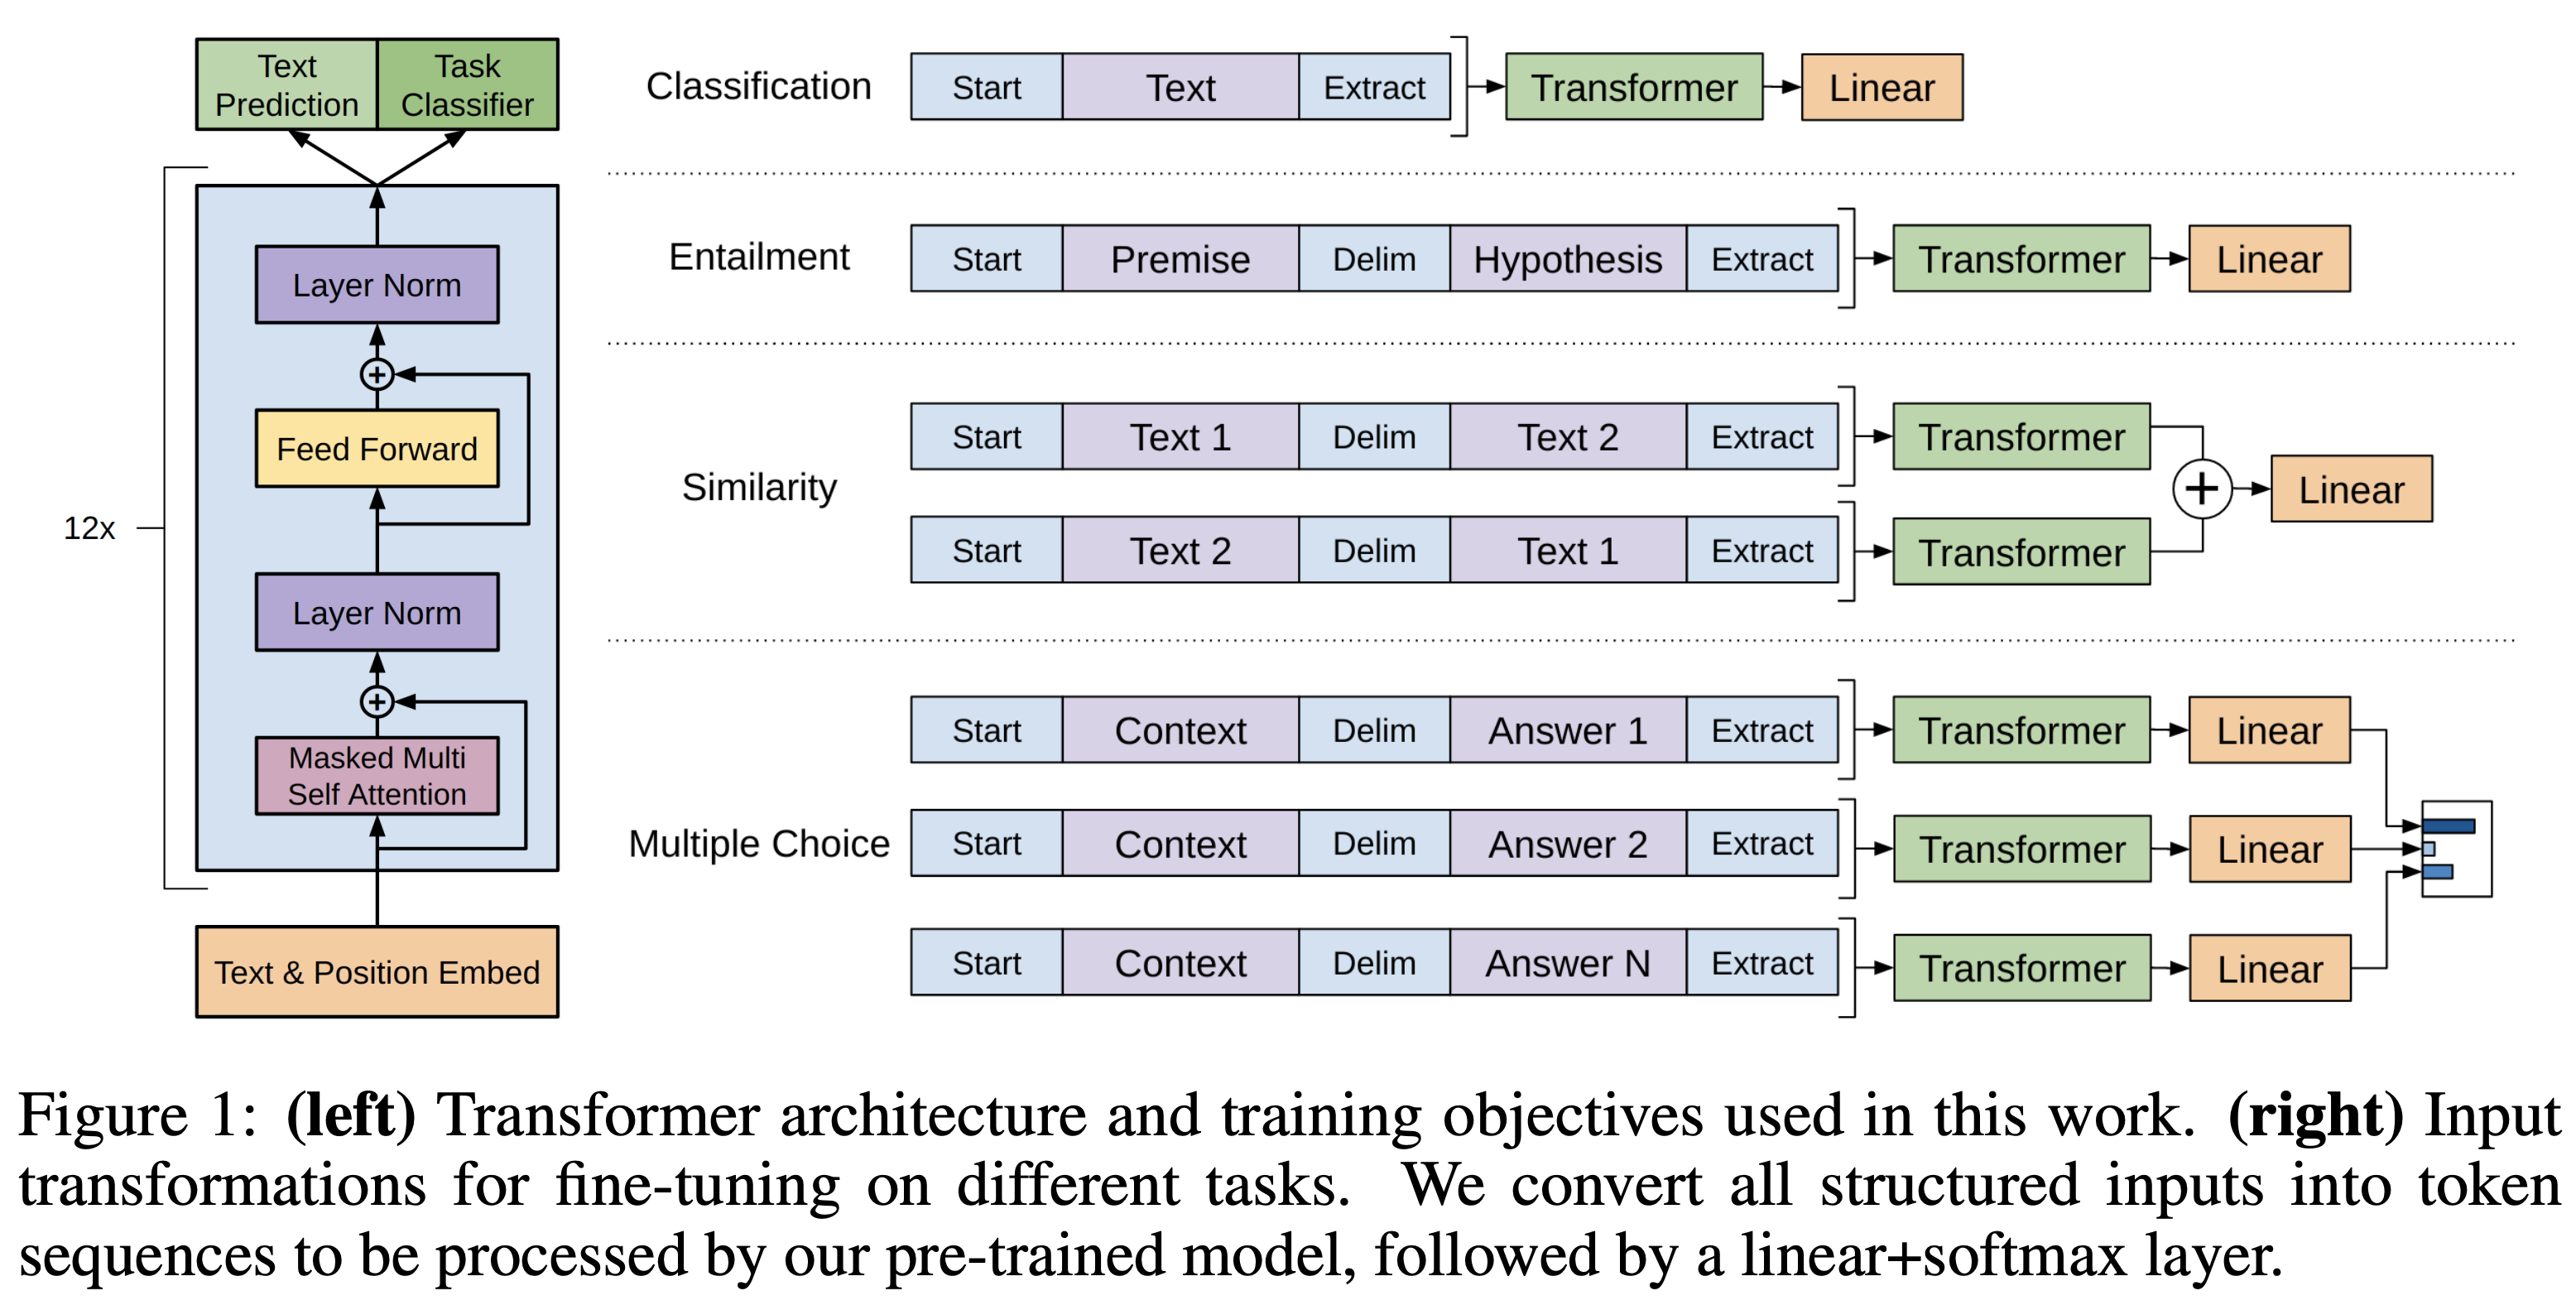

In [27]:
from transformers import OpenAIGPTTokenizer, OpenAIGPTDoubleHeadsModel
import torch

tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
model = OpenAIGPTDoubleHeadsModel.from_pretrained('openai-gpt')
tokenizer.add_special_tokens({'cls_token': '[CLS]'})  # Add a [CLS] to the vocabulary (we should train it also!)
model.resize_token_embeddings(len(tokenizer))

choices = ["Hello, my dog is cute [CLS]", "Hello, my cat is cute [CLS]"]
input_ids = torch.tensor([tokenizer.encode(s) for s in choices]).unsqueeze(0)  # Batch size 1, 2 choices
mc_token_ids = torch.tensor([input_ids.size(-1)-1, input_ids.size(-1)-1]).unsqueeze(0)  # Batch size 1

outputs = model(input_ids, mc_token_ids=mc_token_ids)
lm_prediction_scores, mc_prediction_scores = outputs[:2]
print("lm_prediction_scores: ", lm_prediction_scores)
print("mc_prediction_scores: ", mc_prediction_scores)

Some weights of OpenAIGPTDoubleHeadsModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['multiple_choice_head.summary.bias', 'lm_head.weight', 'multiple_choice_head.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lm_prediction_scores:  tensor([[[[-5.9486e+00, -5.8697e+00, -1.8426e+01,  ..., -1.0449e+01,
            8.8138e-01,  4.3472e-01],
          [-6.1212e+00, -4.8031e+00, -1.4397e+01,  ..., -9.5051e+00,
           -1.2015e+00,  2.0257e-01],
          [-7.4231e+00, -6.3615e+00, -1.4730e+01,  ..., -8.4600e+00,
           -1.5183e+00,  2.5131e-01],
          ...,
          [-5.4751e+00, -5.8803e+00, -1.3777e+01,  ..., -1.2417e+01,
           -6.1584e+00, -4.8927e-01],
          [-7.2052e+00, -6.0198e+00, -2.1504e+01,  ..., -1.4049e+01,
           -1.2416e+00,  4.4382e-02],
          [-9.5612e+00, -8.6814e+00, -2.2013e+01,  ..., -1.2437e+01,
           -1.5145e+00,  2.7358e-01]],

         [[-5.9486e+00, -5.8697e+00, -1.8426e+01,  ..., -1.0449e+01,
            8.8138e-01,  4.3472e-01],
          [-6.1212e+00, -4.8031e+00, -1.4397e+01,  ..., -9.5051e+00,
           -1.2015e+00,  2.0257e-01],
          [-7.4231e+00, -6.3615e+00, -1.4730e+01,  ..., -8.4600e+00,
           -1.5183e+00,  2.5131e-01

### 필요한 파일들
- cloze_test_test__spring2016
https://docs.google.com/spreadsheets/d/11tfmMQeifqP-Elh74gi2NELp0rx9JMMjnQ_oyGKqCEg/edit?usp=sharing

- cloze_test_val__spring2016
https://docs.google.com/spreadsheets/d/1FkdPMd7ZEw_Z38AsFSTzgXeiJoLdLyXY_0B_0JIJIbw/edit?usp=sharing

In [30]:
!python run_openai_gpt.py \
          --model_name openai-gpt \
          --do_train \
          --do_eval \
          --train_dataset "cloze_test_val__spring2016 - cloze_test_ALL_val.csv" \
          --eval_dataset "cloze_test_test__spring2016 - cloze_test_ALL_test.csv" \
          --output_dir ../log \
          --train_batch_size 16 \

2020-07-09 10:47:13.066124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Namespace(adam_epsilon=1e-08, do_eval=True, do_train=True, eval_batch_size=16, eval_dataset='cloze_test_test__spring2016 - cloze_test_ALL_test.csv', gradient_accumulation_steps=1, learning_rate=6.25e-05, lm_coef=0.9, lr_schedule='warmup_linear', max_grad_norm=1, max_steps=-1, model_name='openai-gpt', n_valid=374, num_train_epochs=3, output_dir='../log', seed=42, server_ip='', server_port='', train_batch_size=16, train_dataset='cloze_test_val__spring2016 - cloze_test_ALL_val.csv', warmup_steps=0, weight_decay=0.01)
07/09/2020 10:47:14 - INFO - __main__ -   device: cuda, n_gpu 1
07/09/2020 10:47:16 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-vocab.json from cache at /root/.cache/torch/transformers/4ab93d0cd78ae80e746c27c9cd34e90b470abdabe0590c9ec742df61625ba310.b9

### gpt2를 이용한 텍스트 생성 예시

In [37]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

text_input = "this is one "
text_length = 20
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')

generated = tokenizer.encode(text_input)
context = torch.tensor([generated])
past = None
for i in range(text_length):
  output, past = model(context, past=past)
  token = torch.argmax(output[0, :])
  generated += [token.tolist()]
  context = token.unsqueeze(0)

sequence = tokenizer.decode(generated)

print("Final sequence =>>{}".format(sequence))

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final sequence =>>this is one.

The other is that the "f" is a function of the number of elements in
